## **Proyecto: Análisis de sentimientos con redes neuronales**

**Alumno**: José Jesús Enciso Mayo.

**Curso**: Deep Learning y redes neuronales

Lic. en inteligencia artificial, 5to semestre.

## **Introducción**

El análisis de sentimientos es una herramienta que permite comprender las emociones y opiniones expresadas en textos.

Puede usarse para detectar el estado de ánimo de comunidades en redes sociales tras una crisis, identificar señales tempranas de depresión o ansiedad en foros de apoyo, o analizar la percepción ciudadana sobre políticas públicas.

También es útil para organizaciones sociales y educativas, ya que ayuda a monitorear el bienestar emocional de estudiantes o comunidades vulnerables.

El análisis de sentimientos contribuye a una mejor toma de decisiones y a diseñar intervenciones más humanas y efectivas.

El objetivo de este proyecto es desarrollar un sistema de clasificación multiclase que asigne automáticamente categorías emocionales (Alegría, Miedo, Tristeza, Ira, Esperanza, Sorpresa y Neutro) a comentarios breves (tweets), combinando vocabulario, secuencias e implementando un modelo de red neuronal convolucional 1D.

## **Carga e importación de librerías y recursos**

In [1]:
%pip install pandas numpy torch scikit-learn matplotlib seaborn datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install emoji nltk wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Configuración
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
torch.manual_seed(42)
np.random.seed(42)

Dispositivo: cpu


## **Carga e importación del dataset**

In [ ]:
from datasets import load_dataset

# Cargar los 7 archivos .parquet como un solo dataset
dataset = load_dataset("parquet", data_files="C:/Users/josej/OneDrive/Escritorio/pysentimientosmall/*.parquet")

# Mezclar los registros (opcional) y seleccionar solo 2 millones
sample = dataset["train"].shuffle(seed=42).select(range(1_250_000)) # Local aguanta 590 mil, 1_000_000, 1250000, ...       NO AGUANTA DE 1500000 en adelante

# Convertir solo esa muestra a pandas
df = sample.to_pandas()

## **Preprocesamiento y limpieza de datos**

In [6]:
print(f"Tamaño del dataset: {df.shape}")
print("\nPrimeras filas:")
print(df.head())

Tamaño del dataset: (1250000, 3)

Primeras filas:
                                                text             tweet_id  \
0                 i want to go to new york so bad :(  1206343754388574214   
1    Atypical es alta serie y todos deberían mirarla  1255730749220716544   
2  @grupo8segundos @Alex8segundos @Jaime8segundos...   742754693621776384   
3  Brigar por política ok, agora brigar por macho...  1049447565983408131   
4  Soy Warlock y no me gusta yo kiero ser rogue p...  1308058751317037057   

               user_id  
0           2611958651  
1  1012163611710672896  
2            118935359  
3   962374016139964416  
4           1617620203  


In [7]:
print("\nInformación del dataset:")
print(df.info())


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250000 entries, 0 to 1249999
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   text      1250000 non-null  object
 1   tweet_id  1250000 non-null  object
 2   user_id   1250000 non-null  object
dtypes: object(3)
memory usage: 28.6+ MB
None


In [8]:
# Como no tenemos etiquetas de emociones, vamos a simularlas para el ejercicio
# En un caso real, tendrías que etiquetar manualmente o usar un dataset etiquetado

# Crear etiquetas de emociones simuladas (mismo enfoque que antes)
def asignar_emocion_simulada(texto):
    """
    Función AVANZADA para asignar emociones con:
    - +100 palabras por emoción
    - Niveles de intensidad granular
    - Detección de negaciones
    - Patrones de múltiples palabras
    - Contexto emocional
    """
    if not isinstance(texto, str) or len(texto.strip()) < 3:
        return 'neutral'
        
    texto = texto.lower()
    
    # Palabras de negación que pueden invertir el significado
    negaciones = ['no', 'nunca', 'jamás', 'tampoco', 'nada', 'ni', 'sin']
    
    # Diccionario MUCHO más robusto y organizado
    emociones_palabras = {
        'ira': {
            'palabras': [
                # Núcleo emocional (alta intensidad)
                'odio', 'rabia', 'furioso', 'furiosa', 'asco', 'repugnancia', 'repugnante',
                'indignación', 'indignado', 'indignada', 'cabreo', 'cabreado', 'cabreada',
                'irritación', 'irritado', 'irritada', 'furia', 'enfado', 'enfadado', 'enfadada',
                
                # Expresiones coloquiales
                'estoy harto', 'estoy harta', 'hartazgo', 'cansado de', 'cansada de',
                'no aguanto', 'no soporto', 'me tiene podrido', 'me tiene podrida',
                'qué fastidio', 'qué molestia', 'qué pesadez',
                
                # Intensificadores
                'odio profundo', 'rabia contenida', 'furia incontrolable', 'asco que da',
                'me hierve la sangre', 'echar humo', 'estallar de rabia', 'exasperación',
                
                # Verbos de acción
                'gritar', 'insultar', 'golpear', 'romper', 'destrozar', 'protestar',
                'quejarse', 'reclamar', 'regañar', 'reprender',
                
                # Situaciones detonantes
                'injusticia', 'injusto', 'injusta', 'traición', 'traicionado', 'traicionada',
                'engañado', 'engañada', 'mentira', 'mentiroso', 'mentirosa'
            ],
            'intensidad_base': 3,
            'patrones': [
                (['odio', 'a'], 5), (['rabia', 'da'], 4), (['asco', 'me'], 4),
                (['estoy', 'harto'], 4), (['estoy', 'harta'], 4), (['no', 'aguanto'], 4)
            ]
        },
        
        'alegria': {
            'palabras': [
                # Núcleo emocional
                'feliz', 'felicidad', 'alegre', 'alegría', 'contento', 'contenta', 'gozo',
                'júbilo', 'jubiloso', 'jubilosa', 'euforia', 'eufórico', 'eufórica',
                'entusiasmo', 'entusiasmado', 'entusiasmada', 'dichoso', 'dichosa',
                'satisfecho', 'satisfecha', 'placer', 'agradable',
                
                # Expresiones de disfrute
                'me encanta', 'me fascina', 'me gusta mucho', 'adoro', 'amo',
                'qué bueno', 'qué bien', 'maravilloso', 'fantástico', 'increíble',
                'genial', 'estupendo', 'excelente', 'perfecto', 'perfecta',
                
                # Celebración y logros
                'celebrar', 'fiesta', 'risa', 'reír', 'sonreír', 'sonrisa', 'bailar',
                'cantar', 'brindar', 'triunfo', 'éxito', 'logro', 'victoria',
                'ganar', 'premio', 'recompensa',
                
                # Estados positivos
                'optimista', 'esperanzado', 'esperanzada', 'motivado', 'motivada',
                'energía', 'energético', 'energética', 'vitalidad', 'ánimo',
                
                # Expresiones coloquiales
                'estoy flipando', 'alucinante', 'flipante', 'guay', 'chulo', 'chula',
                'mola', 'molón', 'molona'
            ],
            'intensidad_base': 2,
            'patrones': [
                (['me', 'encanta'], 4), (['qué', 'bueno'], 3), (['estoy', 'feliz'], 4),
                (['muy', 'contento'], 3), (['muy', 'contenta'], 3), (['increíble', 'día'], 3)
            ]
        },
        
        'tristeza': {
            'palabras': [
                # Núcleo emocional
                'triste', 'tristeza', 'deprimido', 'deprimida', 'depresión', 'melancolía',
                'melancólico', 'melancólica', 'desdichado', 'desdichada', 'afligido', 'afligida',
                'desanimado', 'desanimada', 'desolado', 'desolada', 'abatido', 'abatida',
                
                # Expresiones de dolor
                'dolor', 'sufrimiento', 'pena', 'angustia', 'desesperación', 'desesperado', 'desesperada',
                'soledad', 'solitario', 'solitária', 'vacío', 'vacía', 'abandono', 'abandonado', 'abandonada',
                
                # Llanto y duelo
                'llorar', 'lloro', 'lágrimas', 'lagrimas', 'llorando', 'llanto',
                'duelo', 'pérdida', 'perdido', 'perdida', 'ausencia', 'adiós',
                
                # Estados de ánimo bajos
                'desmotivado', 'desmotivada', 'desinterés', 'apatía', 'apático', 'apática',
                'cansancio', 'fatiga', 'agotamiento', 'agotado', 'agotada',
                
                # Situaciones detonantes
                'fracaso', 'fracasado', 'fracasada', 'error', 'equivocación', 'arrepentimiento',
                'decepción', 'decepcionado', 'decepcionada', 'desilusión', 'desilusionado', 'desilusionada'
            ],
            'intensidad_base': 3,
            'patrones': [
                (['muy', 'triste'], 4), (['estoy', 'deprimido'], 5), (['estoy', 'deprimida'], 5),
                (['quiero', 'llorar'], 4), (['me', 'siento', 'solo'], 4), (['me', 'siento', 'sola'], 4)
            ]
        },
        
        'miedo': {
            'palabras': [
                # Núcleo emocional
                'miedo', 'temor', 'susto', 'pánico', 'terror', 'horror', 'espanto',
                'ansiedad', 'angustia', 'nervios', 'nervioso', 'nerviosa', 'intranquilo', 'intranquila',
                'atemorizado', 'atemorizada', 'asustado', 'asustada', 'amedrentado', 'amedrentada',
                
                # Fobias específicas
                'claustrofobia', 'agorafobia', 'aracnofobia', 'aerofobia', 'acrofobia',
                'ansiedad social', 'fobia social', 'trastorno de pánico',
                
                # Reacciones físicas
                'temblar', 'temblor', 'sudor', 'palpitaciones', 'mareo', 'náuseas',
                'paralizado', 'paralizada', 'congelado', 'congelada',
                
                # Situaciones amenazantes
                'peligro', 'peligroso', 'peligrosa', 'amenaza', 'amenazante', 'riesgo', 'arriesgado',
                'incertidumbre', 'incierto', 'incierta', 'desconocido', 'desconocida',
                'oscuro', 'oscuridad', 'sombra', 'fantasma', 'monstruo',
                
                # Expresiones coloquiales
                'me da miedo', 'me aterra', 'me asusta', 'me preocupa', 'me inquieta',
                'estoy nervioso', 'estoy nerviosa', 'tengo ansiedad'
            ],
            'intensidad_base': 3,
            'patrones': [
                (['mucho', 'miedo'], 4), (['me', 'da', 'pánico'], 5), (['estoy', 'asustado'], 4),
                (['estoy', 'asustada'], 4), (['tengo', 'ansiedad'], 4), (['qué', 'susto'], 3)
            ]
        },
        
        'sorpresa': {
            'palabras': [
                # Núcleo emocional
                'sorpresa', 'sorprendido', 'sorprendida', 'asombro', 'asombrado', 'asombrada',
                'impresionante', 'impresionado', 'impresionada', 'increíble', 'extraordinario',
                'inesperado', 'inesperada', 'impactante', 'impactado', 'impactada',
                
                # Expresiones de admiración
                'wow', 'guau', 'increíble', 'alucinante', 'flipante', 'bestial', 'brutal',
                'espectacular', 'magnífico', 'magnífica', 'prodigioso', 'prodigiosa',
                
                # Eventos inesperados
                'de repente', 'repentinamente', 'inesperadamente', 'cuando menos lo esperaba',
                'no me lo esperaba', 'no me lo creo', 'no puede ser', 'es imposible',
                
                # Reacciones
                'quedarse boquiabierto', 'boquiabierto', 'boquiabierta', 'ojos abiertos',
                'no dar crédito', 'quedarse de piedra', 'pasmar', 'pasmado', 'pasmada',
                
                # Cambios bruscos
                'giro inesperado', 'cambio radical', 'revelación', 'descubrimiento',
                'sorpresa mayúscula', 'gran sorpresa'
            ],
            'intensidad_base': 2,
            'patrones': [
                (['qué', 'sorpresa'], 4), (['no', 'puedo', 'creer'], 4), (['me', 'dejó', 'boquiabierto'], 5),
                (['es', 'increíble'], 3), (['qué', 'inesperado'], 3), (['menuda', 'sorpresa'], 4)
            ]
        },
        
        'esperanza': {
            'palabras': [
                # Núcleo emocional
                'esperanza', 'esperar', 'confianza', 'confiar', 'optimismo', 'optimista',
                'fe', 'creer', 'ilusión', 'ilusionado', 'ilusionada', 'positivo', 'positiva',
                'ánimo', 'aliento', 'motivación', 'motivado', 'motivada',
                
                # Futuro y posibilidades
                'futuro', 'mañana', 'próximo', 'próxima', 'venidero', 'venidera',
                'posibilidad', 'oportunidad', 'ocasión', 'posible', 'probable',
                'mejora', 'mejorar', 'progreso', 'avance', 'crecimiento',
                
                # Superación
                'superación', 'superar', 'vencer', 'lograr', 'conseguir', 'alcanzar',
                'triunfar', 'éxito', 'victoria', 'meta', 'objetivo', 'sueño',
                
                # Apoyo y solidaridad
                'apoyo', 'apoyar', 'ayuda', 'ayudar', 'solidaridad', 'solidario', 'solidaria',
                'unión', 'juntos', 'juntas', 'cooperación', 'colaboración',
                
                # Expresiones de confianza
                'todo saldrá bien', 'va a mejorar', 'tiempos mejores', 'hay esperanza',
                'tengo fe', 'confío en', 'estoy seguro', 'estoy segura'
            ],
            'intensidad_base': 2,
            'patrones': [
                (['tengo', 'esperanza'], 4), (['todo', 'saldrá', 'bien'], 4), (['va', 'a', 'mejorar'], 3),
                (['confío', 'en'], 3), (['estoy', 'ilusionado'], 3), (['estoy', 'ilusionada'], 3)
            ]
        }
    }
    
    # Inicializar puntajes
    puntajes = {emocion: 0 for emocion in emociones_palabras.keys()}
    
    # 1. Detectar negaciones en el texto
    tiene_negacion = any(negacion in texto for negacion in negaciones)
    
    # 2. Buscar patrones de múltiples palabras (más confiables)
    for emocion, datos in emociones_palabras.items():
        for patron, peso in datos.get('patrones', []):
            if all(palabra in texto for palabra in patron):
                puntajes[emocion] += peso * 2  # Los patrones valen más
    
    # 3. Buscar palabras individuales
    for emocion, datos in emociones_palabras.items():
        for palabra in datos['palabras']:
            if palabra in texto:
                # Aplicar intensidad base
                puntaje_palabra = datos['intensidad_base']
                
                # Si hay negación cerca de la palabra, reducir puntaje
                if tiene_negacion:
                    # Buscar si la negación está cerca de esta palabra
                    palabras_texto = texto.split()
                    if palabra in palabras_texto:
                        idx_palabra = palabras_texto.index(palabra)
                        # Verificar si hay negación en las 3 palabras anteriores
                        contexto_anterior = palabras_texto[max(0, idx_palabra-3):idx_palabra]
                        if any(neg in contexto_anterior for neg in negaciones):
                            puntaje_palabra = max(1, puntaje_palabra // 2)  # Reducir a la mitad
                
                puntajes[emocion] += puntaje_palabra
    
    # 4. Análisis de contexto adicional
    # Palabras intensificadoras
    intensificadores = ['muy', 'mucho', 'realmente', 'extremadamente', 'totalmente']
    for intensificador in intensificadores:
        if intensificador in texto:
            # Aumentar ligeramente todas las emociones detectadas
            for emocion in puntajes:
                if puntajes[emocion] > 0:
                    puntajes[emocion] += 1
    
    # 5. Encontrar emoción predominante con umbral más estricto
    emocion_predominante = max(puntajes, key=puntajes.get)
    max_puntaje = puntajes[emocion_predominante]
    
    # Umbral más alto para evitar falsos positivos
    if max_puntaje < 3:  # Antes era 0
        return 'neutral'
    
    # 6. Verificar dominancia clara (más estricto)
    puntajes_ordenados = sorted(puntajes.items(), key=lambda x: x[1], reverse=True)
    if len(puntajes_ordenados) > 1:
        diferencia = puntajes_ordenados[0][1] - puntajes_ordenados[1][1]
        # Requerir mayor diferencia para evitar empates
        if diferencia < 3:  # Antes era 2
            return 'neutral'
    
    # 7. Verificar coherencia contextual
    # Si hay muchas emociones con puntaje medio, probablemente sea neutral
    emociones_significativas = sum(1 for p in puntajes.values() if p >= 2)
    if emociones_significativas > 2:
        return 'neutral'
    
    return emocion_predominante

In [9]:
# 7 min, 7 seg
# Aplicar la función para crear etiquetas simuladas
print("Generando etiquetas de emociones...")
df['emocion'] = df['text'].apply(asignar_emocion_simulada)

Generando etiquetas de emociones...


In [10]:
print("Distribución de emociones:")
print(df['emocion'].value_counts())

Distribución de emociones:
emocion
neutral      1170588
tristeza       21713
ira            16895
alegria        14437
esperanza      13708
miedo          10090
sorpresa        2569
Name: count, dtype: int64


In [11]:
# 1.1 Limpieza del corpus
def limpiar_texto(texto):
    if not isinstance(texto, str):
        return ""
    
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Eliminar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    
    # Eliminar menciones de usuario
    texto = re.sub(r'@\w+', '', texto)
    
    # Eliminar hashtags (pero mantener el texto)
    texto = re.sub(r'#', '', texto)
    
    # Eliminar caracteres especiales y números, pero mantener acentos españoles
    texto = re.sub(r'[^a-zA-ZáéíóúñüÁÉÍÓÚÑÜ\s]', '', texto)
    
    # Eliminar espacios extra
    texto = re.sub(r'\s+', ' ', texto).strip()
    
    return texto

In [12]:
# 8 min, 25 seg
print("Limpiando textos...")
df['texto_limpio'] = df['text'].apply(limpiar_texto)
df = df[df['texto_limpio'].str.len() > 5]  # Filtrar textos muy cortos

Limpiando textos...


In [13]:
# 1 min, 42 seg
# Eliminar textos vacíos después de la limpieza
print(f"Tamaño después de limpieza: {df.shape}")

Tamaño después de limpieza: (1151639, 5)


In [14]:
# 1.2 Crear vocabulario y secuencias
def construir_vocabulario(textos, max_vocab_size=10000):
    """Construye un vocabulario a partir de los textos"""
    contador = Counter()
    
    for texto in textos:
        palabras = texto.split()
        contador.update(palabras)
    
    # Tomar las palabras más frecuentes
    vocabulario = {'<PAD>': 0, '<UNK>': 1}
    
    for i, (palabra, _) in enumerate(contador.most_common(max_vocab_size - 2)):
        vocabulario[palabra] = i + 2
    
    return vocabulario

In [15]:
def texto_a_secuencia(texto, vocabulario, max_longitud=100):
    """Convierte texto a secuencia de índices"""
    palabras = texto.split()[:max_longitud]
    secuencia = [vocabulario.get(palabra, vocabulario['<UNK>']) for palabra in palabras]
    
    # Padding si es necesario
    if len(secuencia) < max_longitud:
        secuencia += [vocabulario['<PAD>']] * (max_longitud - len(secuencia))
    
    return secuencia

In [16]:
# Construir vocabulario
print("Construyendo vocabulario...")
vocabulario = construir_vocabulario(df['texto_limpio'].values)
vocab_size = len(vocabulario)
print(f"Tamaño del vocabulario: {vocab_size}")

Construyendo vocabulario...
Tamaño del vocabulario: 10000


In [17]:
# Convertir textos a secuencias
print("Convirtiendo textos a secuencias...")
secuencias = [texto_a_secuencia(texto, vocabulario) for texto in df['texto_limpio'].values]
X = np.array(secuencias)

Convirtiendo textos a secuencias...


In [18]:
# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['emocion'].values)

In [19]:
print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}")

Forma de X: (1151639, 100)
Forma de y: (1151639,)


## **División de datos Train/Dev/Test**

In [20]:
# 1.3 Separación en Train-Dev-Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_dev, y_train, y_dev = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

In [21]:
print(f"Train: {X_train.shape[0]} muestras")
print(f"Dev: {X_dev.shape[0]} muestras")
print(f"Test: {X_test.shape[0]} muestras")

Train: 690983 muestras
Dev: 230328 muestras
Test: 230328 muestras


In [22]:
emociones = label_encoder.classes_
print(f"Emociones: {emociones}")

Emociones: ['alegria' 'esperanza' 'ira' 'miedo' 'neutral' 'sorpresa' 'tristeza']


## **Convirtiendo al formato aceptado por PyTorch**

In [23]:
# ## 2. Representación de los Datos con Embeddings Aprendidos

# %%
# 2.1 Crear DataLoaders para PyTorch
class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [24]:
# Crear datasets
train_dataset = TextDataset(X_train, y_train)
dev_dataset = TextDataset(X_dev, y_dev)
test_dataset = TextDataset(X_test, y_test)

In [25]:
# Crear DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
# 2.2 Validación de las representaciones
print(f"Tamaño del vocabulario: {vocab_size}")
print(f"Longitud de secuencias: {X_train.shape[1]}")
print(f"Rango de índices: [{X_train.min()}, {X_train.max()}]")
print(f"Número de clases: {len(emociones)}")

Tamaño del vocabulario: 10000
Longitud de secuencias: 100
Rango de índices: [0, 9999]
Número de clases: 7


In [27]:
# Verificar una muestra
print("\nEjemplo de secuencia:")
print(f"Texto: {df['texto_limpio'].iloc[9][:100]}...")
print(f"Secuencia: {X_train[9][:20]}...")


Ejemplo de secuencia:
Texto: me había guardado el link para enviártelo por whatsapp te echo de menos...
Secuencia: [ 161    4  631    3   83  558    3    9   33  166   43 9878    1    6
   15   48 2582    4  884 6530]...


## **Implementación del modelo de red neuronal convolucional 1D**

In [28]:
# ## 3. Diseño del Modelo CNN 1D Profundo

# %%
# 3.1 Definición del modelo CNN 1D
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_classes=7, dropout_rate=0.5):
        super(CNNTextClassifier, self).__init__()
        
        # Capa de embedding (aprendida desde cero)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # Capas convolucionales con diferentes tamaños de kernel
        self.conv_layers = nn.ModuleList([
            # Capa 1: kernel pequeño para patrones locales
            nn.Sequential(
                nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.MaxPool1d(2)
            ),
            # Capa 2: kernel mediano
            nn.Sequential(
                nn.Conv1d(128, 256, kernel_size=5, padding=2),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.MaxPool1d(2)
            ),
            # Capa 3: kernel más grande para contextos amplios
            nn.Sequential(
                nn.Conv1d(256, 512, kernel_size=7, padding=3),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.AdaptiveAvgPool1d(10)  # Pooling adaptativo para tamaño fijo
            )
        ])
        
        # Capas fully connected profundas
        self.classifier = nn.Sequential(
            nn.Linear(512 * 10, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, num_classes)
        )
        
        # Inicialización de pesos
        self._initialize_weights()
    
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv1d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm1d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        # Embedding: (batch, seq_len) -> (batch, seq_len, embed_dim)
        x = self.embedding(x)
        
        # Transponer para convoluciones: (batch, seq_len, embed_dim) -> (batch, embed_dim, seq_len)
        x = x.transpose(1, 2)
        
        # Aplicar capas convolucionales
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        
        # Aplanar para fully connected
        x = x.view(x.size(0), -1)
        
        # Clasificación final
        x = self.classifier(x)
        
        return x

In [29]:
# Instanciar el modelo
embed_dim = 128
num_classes = len(emociones)

model = CNNTextClassifier(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_classes=num_classes,
    dropout_rate=0.5
).to(device)

In [30]:
print("Modelo CNN 1D creado:")
print(f"- Vocabulario: {vocab_size}")
print(f"- Embedding dim: {embed_dim}")
print(f"- Clases: {num_classes}")
print(f"- Parámetros totales: {sum(p.numel() for p in model.parameters()):,}")

Modelo CNN 1D creado:
- Vocabulario: 10000
- Embedding dim: 128
- Clases: 7
- Parámetros totales: 8,318,599


## **Configuración general del entrenamiento del modelo**

In [31]:
# Configurar entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [32]:
# 3.1 Función de entrenamiento
def entrenar_modelo_profundo(model, train_loader, dev_loader, epochs=10):
    train_losses = []
    dev_accuracies = []
    best_accuracy = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        total_loss = 0
        batch_count = 0
        
        for batch_sequences, batch_labels in train_loader:
            batch_sequences = batch_sequences.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            
            # Gradient clipping para estabilidad
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            batch_count += 1
        
        # Evaluación en desarrollo
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_sequences, batch_labels in dev_loader:
                batch_sequences = batch_sequences.to(device)
                batch_labels = batch_labels.to(device)
                
                outputs = model(batch_sequences)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
        
        accuracy = 100 * correct / total
        avg_loss = total_loss / batch_count
        
        train_losses.append(avg_loss)
        dev_accuracies.append(accuracy)
        
        # Actualizar scheduler
        scheduler.step(accuracy)
        
        # Guardar mejor modelo
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, 'mejor_modelo_cnn.pth')
        
        print(f'Época [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy Dev: {accuracy:.2f}%')
    
    # Cargar mejor modelo
    model.load_state_dict(best_model_state)
    return train_losses, dev_accuracies

In [33]:
print("Comenzando entrenamiento del modelo CNN profundo...")
train_losses, dev_accuracies = entrenar_modelo_profundo(model, train_loader, dev_loader, epochs=10)

Comenzando entrenamiento del modelo CNN profundo...
Época [1/10], Loss: 0.2556, Accuracy Dev: 94.06%
Época [2/10], Loss: 0.1826, Accuracy Dev: 94.54%
Época [3/10], Loss: 0.1640, Accuracy Dev: 94.30%
Época [4/10], Loss: 0.1509, Accuracy Dev: 95.46%
Época [5/10], Loss: 0.1423, Accuracy Dev: 96.27%
Época [6/10], Loss: 0.1348, Accuracy Dev: 96.01%
Época [7/10], Loss: 0.1298, Accuracy Dev: 96.56%
Época [8/10], Loss: 0.1247, Accuracy Dev: 96.78%
Época [9/10], Loss: 0.1218, Accuracy Dev: 96.37%
Época [10/10], Loss: 0.1184, Accuracy Dev: 96.76%


In [34]:
# ## 5. Guardar Modelo y Componentes para Uso Futuro

# %%
import pickle
import json

def guardar_modelo_completo(model, vocabulario, label_encoder, X_train, filepath='modelo_emociones_completo.pkl'):
    """Guarda el modelo y todos los componentes necesarios para recargarlo"""
    
    # Guardar el estado del modelo
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': {
            'vocab_size': model.embedding.num_embeddings,
            'embed_dim': model.embedding.embedding_dim,
            'num_classes': model.classifier[-1].out_features
        },
        'vocabulario': vocabulario,
        'label_encoder': label_encoder,
        'configuracion': {
            'max_longitud': X_train.shape[1],
            'emociones': label_encoder.classes_.tolist()
        }
    }, filepath)
    
    print(f"Modelo guardado en: {filepath}")
    print(f"   - Vocabulario: {len(vocabulario)} palabras")
    print(f"   - Emociones: {len(label_encoder.classes_)} clases")
    print(f"   - Longitud secuencia: {X_train.shape[1]}")

# Guardar el modelo
guardar_modelo_completo(model, vocabulario, label_encoder, X_train, 'modelo_emociones_cnn.pkl')

Modelo guardado en: modelo_emociones_cnn.pkl
   - Vocabulario: 10000 palabras
   - Emociones: 7 clases
   - Longitud secuencia: 100


## **Visualización de resultados del modelo**

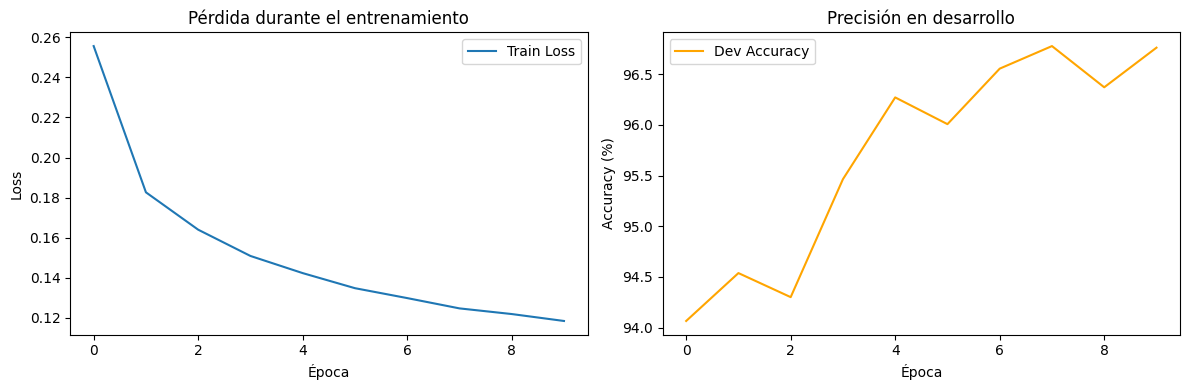

In [35]:
# Gráficas de entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dev_accuracies, label='Dev Accuracy', color='orange')
plt.title('Precisión en desarrollo')
plt.xlabel('Época')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## **Evaluación, métricas y resultados**

In [36]:
# 3.2 Pruebas con el modelo
def evaluar_modelo_completo(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch_sequences, batch_labels in test_loader:
            batch_sequences = batch_sequences.to(device)
            batch_labels = batch_labels.to(device)
            
            outputs = model(batch_sequences)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return (np.array(all_predictions), 
            np.array(all_labels), 
            np.array(all_probabilities))

In [37]:
print("Evaluando en conjunto de prueba...")
y_pred, y_true, y_probs = evaluar_modelo_completo(model, test_loader)

Evaluando en conjunto de prueba...


In [38]:
# 3.3 Métricas completas del modelo
print("=== MÉTRICAS DEL MODELO CNN 1D ===")

# Métricas principales
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
kappa = cohen_kappa_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"Kappa de Cohen: {kappa:.4f}")

=== MÉTRICAS DEL MODELO CNN 1D ===
Accuracy: 0.9678
F1-Score (macro): 0.7536
Kappa de Cohen: 0.7134


In [39]:
# Reporte de clasificación detallado
print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_true, y_pred, target_names=emociones))

# Precisión por clase
print("\n=== PRECISIÓN POR CLASE ===")
report = classification_report(y_true, y_pred, target_names=emociones, output_dict=True)
for emocion in emociones:
    precision = report[emocion]['precision']
    recall = report[emocion]['recall']
    f1 = report[emocion]['f1-score']
    support = report[emocion]['support']
    print(f"{emocion:12} - Prec: {precision:.3f}, Rec: {recall:.3f}, F1: {f1:.3f}, Support: {support}")


=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

     alegria       0.88      0.54      0.67      2884
   esperanza       0.82      0.34      0.49      2740
         ira       0.88      0.67      0.76      3340
       miedo       0.90      0.68      0.77      2005
     neutral       0.97      0.99      0.98    214542
    sorpresa       0.79      0.82      0.80       514
    tristeza       0.89      0.73      0.80      4303

    accuracy                           0.97    230328
   macro avg       0.88      0.68      0.75    230328
weighted avg       0.97      0.97      0.96    230328


=== PRECISIÓN POR CLASE ===
alegria      - Prec: 0.878, Rec: 0.539, F1: 0.668, Support: 2884.0
esperanza    - Prec: 0.822, Rec: 0.345, F1: 0.486, Support: 2740.0
ira          - Prec: 0.883, Rec: 0.666, F1: 0.759, Support: 3340.0
miedo        - Prec: 0.897, Rec: 0.678, F1: 0.772, Support: 2005.0
neutral      - Prec: 0.972, Rec: 0.994, F1: 0.983, Support: 214542.0
sor

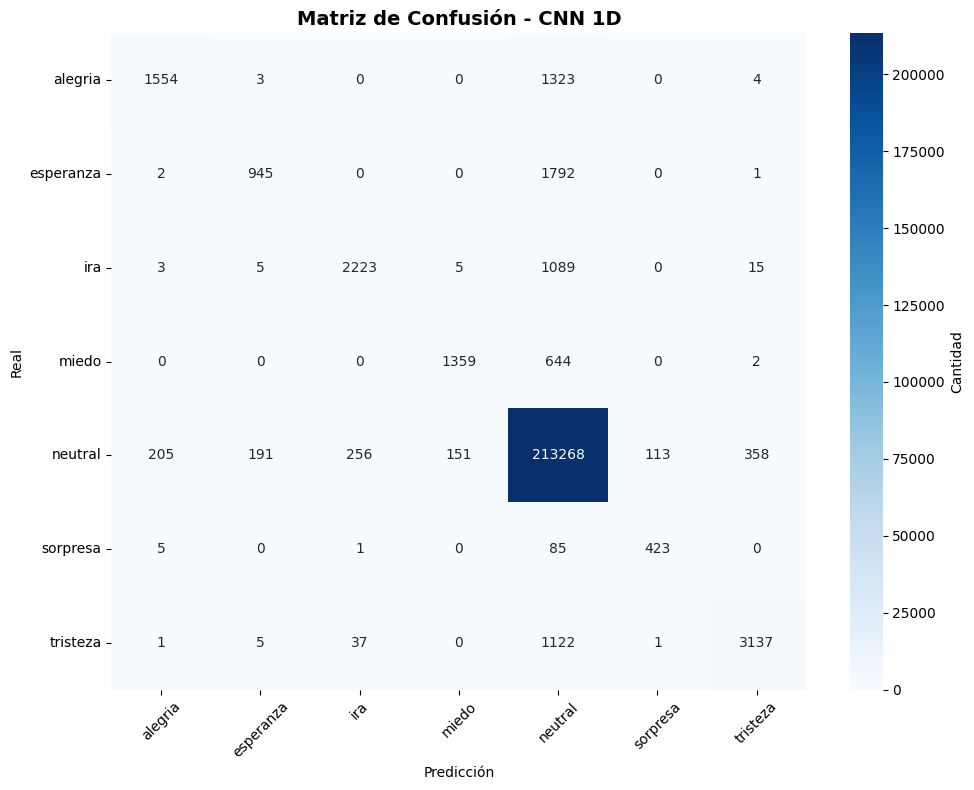

In [40]:
# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emociones, yticklabels=emociones,
            cbar_kws={'label': 'Cantidad'})
plt.title('Matriz de Confusión - CNN 1D', fontsize=14, fontweight='bold')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [41]:
# Análisis de embeddings aprendidos
def visualizar_embeddings(model, vocabulario, top_n=20):
    """Visualiza los embeddings más importantes"""
    embeddings = model.embedding.weight.data.cpu().numpy()
    
    # Obtener palabras más frecuentes
    palabras_comunes = list(vocabulario.keys())[:top_n]
    indices_comunes = list(vocabulario.values())[:top_n]
    
    print("Embeddings para palabras comunes:")
    for palabra, idx in zip(palabras_comunes[:10], indices_comunes[:10]):
        if idx < len(embeddings):
            embedding_norm = np.linalg.norm(embeddings[idx])
            print(f"  {palabra:15} - Norma: {embedding_norm:.4f}")

visualizar_embeddings(model, vocabulario)

Embeddings para palabras comunes:
  <PAD>           - Norma: 0.0000
  <UNK>           - Norma: 6.3478
  de              - Norma: 8.1889
  que             - Norma: 7.8686
  la              - Norma: 8.6564
  a               - Norma: 9.0254
  y               - Norma: 9.0261
  el              - Norma: 8.5548
  no              - Norma: 9.8984
  en              - Norma: 9.4199


## **Sistema de predicción y pruebas con el modelo**

In [42]:
# Función de predicción para nuevos textos
def predecir_emocion_cnn(texto, model, vocabulario, label_encoder, max_longitud=100):
    """Predice la emoción de un nuevo texto usando el modelo CNN"""
    model.eval()
    
    # Preprocesar
    texto_limpio = limpiar_texto(texto)
    secuencia = texto_a_secuencia(texto_limpio, vocabulario, max_longitud)
    
    # Convertir a tensor
    input_tensor = torch.LongTensor([secuencia]).to(device)
    
    # Predecir
    with torch.no_grad():
        output = model(input_tensor)
        probabilidades = torch.softmax(output, dim=1)
        _, prediccion = torch.max(output, 1)
        emocion = label_encoder.inverse_transform(prediccion.cpu().numpy())[0]
        confianza = probabilidades[0][prediccion].item()
    
    return emocion, confianza

In [43]:
# Ejemplos de predicción
print("=== EJEMPLOS DE PREDICCIÓN CON CNN ===")
ejemplos_prueba = [
    "Estoy muy feliz y contento con la vida!",
    "Me da mucho miedo el futuro incierto",
    "Estoy tan triste que no sé qué hacer",
    "Qué rabia me da esta situación injusta",
    "Tengo esperanza de que todo mejorará pronto",
    "Qué sorpresa más agradable me he llevado hoy!"
]

for ejemplo in ejemplos_prueba:
    emocion, confianza = predecir_emocion_cnn(ejemplo, model, vocabulario, label_encoder)
    print(f"Texto: '{ejemplo}'")
    print(f"→ Emoción: {emocion} (confianza: {confianza:.3f})\n")

=== EJEMPLOS DE PREDICCIÓN CON CNN ===
Texto: 'Estoy muy feliz y contento con la vida!'
→ Emoción: alegria (confianza: 0.970)

Texto: 'Me da mucho miedo el futuro incierto'
→ Emoción: neutral (confianza: 0.889)

Texto: 'Estoy tan triste que no sé qué hacer'
→ Emoción: tristeza (confianza: 0.852)

Texto: 'Qué rabia me da esta situación injusta'
→ Emoción: ira (confianza: 0.962)

Texto: 'Tengo esperanza de que todo mejorará pronto'
→ Emoción: neutral (confianza: 0.914)

Texto: 'Qué sorpresa más agradable me he llevado hoy!'
→ Emoción: neutral (confianza: 0.760)



In [ ]:
# %% [markdown]
# ## 4. Predicción Simple para Usuario

# %%
def prediccion_simple():
    """Versión simple para probar el modelo"""
    print("PREDICCIÓN DE EMOCIONES - MODO SIMPLE")
    print("Escribe textos en español y el modelo predecirá la emoción.")
    print("Escribe 'salir' para terminar.\n")
    
    while True:
        texto = input("Texto: ").strip()
        
        if texto.lower() in ['salir', 'exit', 'quit']:
            break
            
        if texto:
            emocion, confianza = predecir_emocion_cnn(texto, model, vocabulario, label_encoder)
            print(f"→ Emoción: {emocion} ({confianza:.1%})")
            print()

# Ejecutar la versión simple
prediccion_simple()

## **Resúmen (parámetros y resultados generales de las métricas)**

In [44]:
# Análisis final de resultados
print("=== ANÁLISIS FINAL DEL MODELO CNN 1D ===")
print(f"1. Arquitectura: CNN 1D Profunda con Embeddings Aprendidos")
print(f"2. F1-Score Macro: {f1_macro:.4f}")
print(f"3. Accuracy General: {accuracy:.4f}")
print(f"4. Kappa de Cohen: {kappa:.4f}")
print(f"5. Tamaño del vocabulario: {vocab_size}")
print(f"6. Dimensiones de embedding: {embed_dim}")
print(f"7. Parámetros totales: {sum(p.numel() for p in model.parameters()):,}")

=== ANÁLISIS FINAL DEL MODELO CNN 1D ===
1. Arquitectura: CNN 1D Profunda con Embeddings Aprendidos
2. F1-Score Macro: 0.7536
3. Accuracy General: 0.9678
4. Kappa de Cohen: 0.7134
5. Tamaño del vocabulario: 10000
6. Dimensiones de embedding: 128
7. Parámetros totales: 8,318,599


In [45]:
# Identificar fortalezas y debilidades
print("\n=== ANÁLISIS DE CLASES ===")
for emocion in emociones:
    f1 = report[emocion]['f1-score']
    estado = "✓ BUENO" if f1 > 0.7 else "⚠ REGULAR" if f1 > 0.5 else "✗ BAJO"
    print(f"{emocion:12} - F1: {f1:.3f} {estado}")


=== ANÁLISIS DE CLASES ===
alegria      - F1: 0.668 ⚠ REGULAR
esperanza    - F1: 0.486 ✗ BAJO
ira          - F1: 0.759 ✓ BUENO
miedo        - F1: 0.772 ✓ BUENO
neutral      - F1: 0.983 ✓ BUENO
sorpresa     - F1: 0.805 ✓ BUENO
tristeza     - F1: 0.802 ✓ BUENO
